In [1]:
import deeptrack as dt
from deeptrack.models.yolo import utils
import numpy as np
import matplotlib.pyplot as plt

from simulation import *

c:\Users\santh\Desktop\VScode\Particle_Chamber\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\santh\Desktop\VScode\Particle_Chamber\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [2]:
sim= MultiParticle(
    
    
    n_particles = lambda: int(np.random.rand()*10) + 15,
        
    
)
starting_value = dt.Value(lambda: np.ones((IMAGE_SIZE, IMAGE_SIZE)))

sim= starting_value >> MultiParticle(
    n_particles = lambda: int(np.random.rand()*10) + 15,
)

particle =  sim[0]
pos =  sim[1]
rad =  sim[2]






In [3]:
print(np.shape(particle.resolve()))

Image((100, 100, 1))


In [4]:
gradient = dt.IlluminationGradient(
    gradient=[.5e-3, 0e-3],#lambda: 1e-3 + np.random.randn(2) * 1e-3,
)

class Normalize(dt.Feature):
    def __init__(
        self, **kwargs
    ):
        super().__init__( **kwargs)

    def get(self, image, **kwargs):
        image = image / np.max(image)
        return image

normalization = Normalize()

gauss = dt.Gaussian(mu = 0, sigma = .01)

import scipy
#Smoothing
kernel = np.ones((3, 3)) / 15
smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel)) 

particle = particle  >> gauss >> normalization 

In [5]:
"""def get_label(a, b):
    a = a.resolve()
    b = b.resolve()
    n = int(np.shape(a)[0])
    label = np.zeros((n,4))

    for i in range(n):
        label[i,:] = [int(a[i, 0]), int(a[i, 1]), b[i], b[i]]

    
    return label #(np.asarray(a.resolve()), np.asarray(b.resolve()))"""

def get_label(rad, pos):
    rad = np.array(rad)
    rad = rad.astype(int)
    pos = np.array(pos)
    pos = pos.astype(int)    

    n = np.shape(rad)[0]  
    label = np.zeros((n, 5))
    top_left = np.zeros((n,2))
    bottom_right = np.zeros((n,2))
    top_left[:,0] = pos[:, 0]- rad[:,0]
    top_left[:,1] = pos[:, 1]- rad[:,0]
    bottom_right[:,0] = pos[:, 0]+ rad[:,0]
    bottom_right[:,1] = pos[:, 1]+ rad[:,0]

    for i in range ( n ):
        label[i, : ] = [int(top_left[i,1]), int(top_left[i,0]), int(bottom_right[i, 1]), int(bottom_right[i,0]), int(0)]
    
    #print(label)
    return label.astype(int)

In [6]:


label_func = particle >> dt.Lambda(lambda rad, pos: lambda x: get_label(rad, pos), rad=rad, pos=pos)
#bboxes.resolve()
#data = particle & bboxes
#print(data.resolve())


print(label_func.resolve())

Image(array([[ 87,   2,  91,   6,   0],
       [ 41,  96,  45, 100,   0],
       [ 92,  48,  96,  52,   0],
       [ 43,  18,  47,  22,   0],
       [ 45,  39,  49,  43,   0],
       [ 19,  69,  23,  73,   0],
       [ 72,  15,  76,  19,   0],
       [ 59,  57,  63,  61,   0],
       [ 92,  28,  96,  32,   0],
       [ 17,  64,  21,  68,   0],
       [ 44,  54,  48,  58,   0],
       [ 26,  56,  30,  60,   0],
       [ 41,  74,  45,  78,   0],
       [ 64,   9,  68,  13,   0],
       [ 44,  86,  48,  90,   0]]))


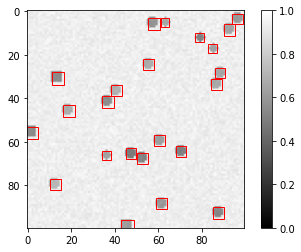

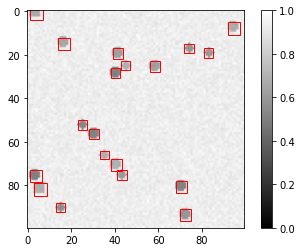

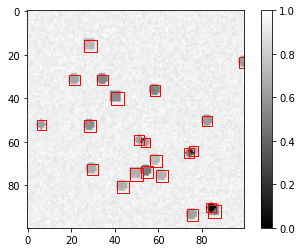

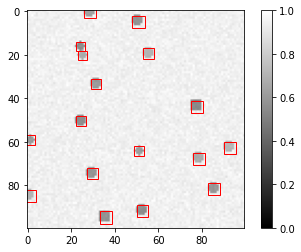

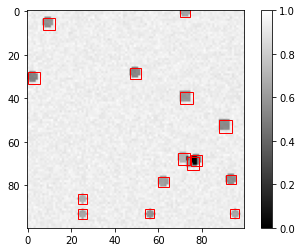

In [11]:
NUMBER_OF_IMAGES = 5

for _ in range(NUMBER_OF_IMAGES):
    particle.update()
    pos = pos.update()
    rad = rad.update()
    
    bboxes = label_func.resolve()

    
    #print(np.array(bboxes))
    image_of_particle = particle.resolve()
    

    rad
    n = np.shape(bboxes)[0]
    position_of_particles = bboxes[:,0:4]
    #print(position_of_particles)
    radius_of_particles = np.array(rad.resolve())
    
    plt.imshow(image_of_particle.reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="gray", vmin = 0)
    plt.colorbar()
    ax = plt.gca()
    for i in range(int(n)):
        rect = plt.Rectangle((position_of_particles[i,1],position_of_particles[i,0]),2*radius_of_particles[i],2*radius_of_particles[i],linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    
    #plt.scatter(position_of_particles[:,0], position_of_particles[:,1], marker='+', edgecolors="r", linewidth=2)
    plt.show()

In [12]:
from deeptrack.models.yolo.yolo import YOLOv3

model = YOLOv3(
    (100, 100, 1),
    1,
)

model.compile(optimizer="adam")

In [13]:
from deeptrack.models.yolo.dataset import YoloDataGenerator

data = particle & bboxes

generator = YoloDataGenerator(
    feature=data,
    input_size=np.array([100]),
    num_class=1,
    label_function=lambda d: np.array(d[1]),
    batch_size=4,
    min_data_size=100,
    max_data_size=200,
)

generator.anchors = model.anchors

In [14]:
with generator:
    model.fit(generator, epochs=50)

Generating 107 / 100 samples before starting training
Epoch 1/50
 3/26 [==>...........................] - ETA: 29s - loss: 117.5807 - giou_loss: 23.8097 - conf_loss: 84.7355 - prob_loss: 9.0355

KeyboardInterrupt: 